# [实验四报告](https://github.com/YuweiWen1217/2024-MachineLearning)
文昱韦 2213125

#### 实验四：朴素贝叶斯分类器
1. **初级要求**：采用分层采样的方式将数据集划分为训练集和测试集；给定编写一个朴素贝叶斯分类器，对测试机进行预测，计算分类准确率
2. **中级要求**：使用测试机评估模型，得到混淆矩阵、精度、召回率、F值
3. **高级要求**：在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值

##### 初级要求

贝叶斯定理描述了事件发生的条件概率，公式如下：
$$
P(C_k | X) = \frac{P(X | C_k) \cdot P(C_k)}{P(X)}
$$

基于贝叶斯公式来估计后验概率$P(C_k | X)$的主要困难在于：类条件概率$P(X|C_k)$是所有属性上的联合概率，难以从有限的训练样本直接估计而得。为避开这个障碍，朴素贝叶斯分类器采用了**属性条件独立性假设**：对已知类别，假设所有属性相互独立。换言之，假设每个属性独立地对分类结果发生影响。

基于属性条件独立性假设，后验概率 $ P(C_k | X) $可以重写成：

$$
P(C_k | X) = \frac{P(C_k) \prod_{i=1}^{n} P(X_i | C_k)}{P(X)}
$$

分类的目标是选择使后验概率最大化的类别 $ C_k $，即：

$$
\hat{C} = \arg\max_{C_k} P(C_k) \prod_{i=1}^{n} P(X_i | C_k)
$$

- **先验概率 $ P(C_k) $**：
$$
P(C_k) = \frac{\text{类别 } C_k \text{ 的样本数}}{\text{总样本数}}
$$

- **条件概率 $ P(X_i | C_k) $**：表示在类别 $ C_k $ 下，特征 $ X_i $ 取某个值的概率。wine数据集中，特征均是连续的，考虑假设其服从高斯分布，则概率密度函数为：
$$
P(X_i | C_k) = \frac{1}{\sqrt{2\pi \sigma_{i,k}^2}} \exp\left(-\frac{(X_i - \mu_{i,k})^2}{2\sigma_{i,k}^2}\right)
$$



特殊说明：
1. 本题只考虑概率值之间的相对大小，为避免数值下溢，**实现时将“连乘”转换为了“取对数再相加”**。
2. 由于本题采用分层采样划分数据集，且所有特征均是连续的，**因此实现过程没有使用拉普拉斯修正**。

In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [2]:
data = np.loadtxt('wine.data', delimiter=',')
X = data[:, 1:]  # 特征
y = data[:, 0].astype(int)  # 标签
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# 朴素贝叶斯分类器
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_probs = {}  # 每个类别的先验概率
        self.means = {}  # 每个类别中每个特征的均值
        self.stds = {}  # 每个类别中每个特征的标准差
        # 计算每个类别的先验概率、特征均值、特征标准差
        for c in self.classes:
            class_samples = X[y == c]
            self.class_probs[c] = len(class_samples) / len(y)
            self.means[c] = np.mean(class_samples, axis=0)
            self.stds[c] = np.std(class_samples, axis=0)
    def predict(self, X):
        predictions = []
        prob_matrix = []
        for x in X:
            class_probs = {}
            # 对每个类别计算后验概率
            for c in self.classes:
                prior = np.log(self.class_probs[c]) 
                likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.stds[c]**2)) - 0.5 * np.sum(((x - self.means[c])**2) / (self.stds[c]**2))
                # 总概率是先验和条件概率的乘积（取对数后为和）
                class_probs[c] = prior + likelihood
            prob_matrix.append(class_probs)
            predictions.append(max(class_probs, key=class_probs.get))
        prob_matrix = np.array([[class_probs[c] for c in self.classes] for class_probs in prob_matrix])
        return np.array(predictions), np.array(prob_matrix)


model = NaiveBayes()
model.fit(X_train, y_train)
y_pred, prob_matrix = model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"分类准确率: {accuracy:.4f}")

分类准确率: 0.9815


根据输出结果，分类准确率为98%。

#### 中级要求

##### 1. 混淆矩阵（Confusion Matrix）

对于一个二分类问题，混淆矩阵通常包含以下四个指标：

- **真阳性（True Positives，TP）**：模型正确地预测为正类的样本数。
- **假阳性（False Positives，FP）**：模型错误地预测为正类的样本数。
- **真阴性（True Negatives，TN）**：模型正确地预测为负类的样本数。
- **假阴性（False Negatives，FN）**：模型错误地预测为负类的样本数。

对于多分类问题，混淆矩阵是一个二维矩阵，其中每一行表示实际类别，每一列表示预测类别，矩阵中的元素表示对应类别的预测数量。

##### 2. 评估指标

| 指标         | 公式                                                | 说明                       |
|--------------|-----------------------------------------------------|----------------------------|
| 精度         | $\text{精度} = \frac{TP}{TP + FP}$                   | 预测为正类样本中有多少是正类 |
| 召回率       | $\text{召回率} = \frac{TP}{TP + FN}$                 | 正类样本中有多少被正确预测 |
| F1 值        | $\text{F1值} = 2 \cdot \frac{\text{精度} \cdot \text{召回率}}{\text{精度} + \text{召回率}}$ | 精度和召回率的调和平均数     |

在本题要求下，我们可以先计算混淆矩阵，再计算每个类别下的精度、召回率、F1。例如，对于类别1来说，混淆矩阵的第一列之和，就是所有预测为正例的数量（精度的分母），第一行之和就是所有实际为正例的数量（召回率分母），第一行第一列的值即为TP。


In [3]:
# 计算混淆矩阵
conf_matrix = np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int)
for true, pred in zip(y_test, y_pred):
    conf_matrix[true - 1, pred - 1] += 1

print("混淆矩阵:")
print(conf_matrix)

# 计算精度、召回率和F1值
def precision_recall_f1(conf_matrix):
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

precision, recall, f1 = precision_recall_f1(conf_matrix)

print("精度:", precision)
print("召回率:", recall)
print("F1值:", f1)

混淆矩阵:
[[17  1  0]
 [ 0 21  0]
 [ 0  0 15]]
精度: [1.         0.95454545 1.        ]
召回率: [0.94444444 1.         1.        ]
F1值: [0.97142857 0.97674419 1.        ]


由结果可知，除了有1个实际为类别1的样本被错误地分类到了类别2之外，其它样本都分类正确。这1个样本的错误导致类别1的召回率和类别2的精度不是100%，进而导致F1在97%~98%之间。但总体来说，分类效果表现得相当优异。

#### 高级要求

ROC 曲线是二分类问题中用来评估分类模型性能的图形工具。它展示了模型在不同阈值下的表现，具体为FPR和TPR之间的关系。通过画出 ROC 曲线，可以直观地看出分类器在不同阈值下的表现，通常可以帮助我们选择最佳的分类阈值。

要画出一个ROC曲线，我们需要三个数值：预测标签、真实标签、预测“分数”（如概率等）。由于是二分类问题，对于真实标签，以类别1为例，如果某个测试样本为类别1，其预测标签就为1，反之则为0。预测标签同理。本题中，预测分数就是取对数后的后验概率值，画ROC曲线时，我们依旧只需要数值之间的相对大小关系。

画出曲线需要一系列FPR和TPR值，分别作为横坐标和纵坐标，两数的分母不变，分别是类别i的实际数量和其他类别的实际数量。分子分别是TP和FP，初始化时阈值很高，即所有样本均视作反例，因此两数均为0。

我们将分数从大到小排序，然后依次获取一个样本的实际标签（相当于降低阈值，分数相同时需要获取多个样本），属于当前类（标签为1），则TP加1，反之则FP加1，然后将计算此时的FPR和TPR值。获取完所有样本就可以得到一系列的FPR和TPR值，并按照这些值进行画图。在图像上表现为，从左下角的点开始，遇到属于该类的样本，则向上移动一格，遇到不属于该类的样本，则向右移动一格。

AUC 是 ROC 曲线下的面积，它可以作为模型性能的一个指标。AUC 的值在 $[0, 1]$ 之间，值越接近 1 表示模型性能越好，值越接近 0.5 表示模型表现接近随机猜测。本题中，我们直接调用了sklearn的库函数进行计算。

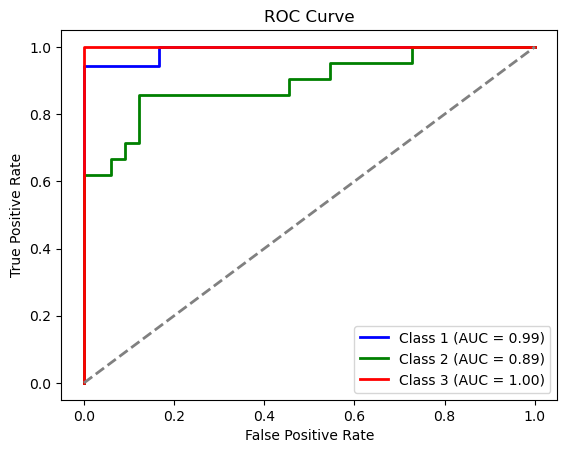

In [4]:
def roc(y_true, y_score, pos_label):
    """
    y_true: 真实标签，该类为1，不是该类为0
    y_score: 属于该类的分数（越高表示越有可能属于该类）
    pos_label: 1
    """
    # 统计正样本和负样本的个数
    num_positive_examples = (y_true == pos_label).sum()
    num_negtive_examples = len(y_true) - num_positive_examples
    tp, fp = 0, 0
    tpr, fpr = [], []
    score = max(y_score) + 1
    for i in np.flip(np.argsort(y_score)):
        if y_score[i] != score:
            fpr.append(fp / num_negtive_examples)
            tpr.append(tp / num_positive_examples)
            score = y_score[i]    
        if y_true[i] == pos_label:
            tp += 1
        else:
            fp += 1
    fpr.append(fp / num_negtive_examples)
    tpr.append(tp / num_positive_examples)
    return fpr, tpr

# 二值化
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# 获取每个类别的 FPR 和 TPR
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

for i in range(prob_matrix.shape[1]):  # 遍历每一列，对应每个类别
    # 对于每个类别，从 prob_matrix 中取出该类别的预测概率
    fpr, tpr = roc(y_test_bin[:, i], prob_matrix[:, i], pos_label=1)
    # 存储 FPR、TPR 和 AUC
    fpr_dict[i] = fpr
    tpr_dict[i] = tpr
    roc_auc_dict[i] = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
colors = ['blue', 'green', 'red']
for i in range(prob_matrix.shape[1]):  # 绘制每个类别的 ROC 曲线
    plt.plot(fpr_dict[i], tpr_dict[i], color=colors[i], lw=2,
             label=f'Class {i + 1} (AUC = {roc_auc_dict[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

由图可知，对于类别1的AUC值为 0.99，类别2的AUC值为 0.89，类别3的AUC值为1。模型在类别1和类别3上的分类效果非常好，在类别2上的分类效果也比较好。图中左下角的点开始，三条曲线都是直接向上发展的，可知对于每种类别下分数排在前面的样本，分类都是十分准确的。